In [1]:
import torch
import numpy as np
import cv2
import ipdb
import scipy

# from torch import nn
from PIL import Image, ImageOps
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import matrix_rank, inv
from numpy.random import permutation
from scipy.linalg import eigh
from scipy.linalg import norm as mnorm
from scipy.stats import ortho_group

import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR

import os


import ica

from modules.util import getdata

In [2]:
class infomaxICA(nn.Module):

    def __init__(self, n, bias=True):
        super(infomaxICA, self).__init__()
        self.W1 = torch.nn.Linear(n, n, bias=bias)
        with torch.no_grad():
            self.W1.weight = nn.Parameter(torch.diag(torch.ones(n)))
            if bias:
                self.W1.bias = nn.Parameter(torch.zeros(n))
        

        self.W2 = torch.nn.Linear(n, n, bias = bias)
        with torch.no_grad():
            self.W2.weight = nn.Parameter(torch.diag(torch.ones(n)))
            if bias:
                self.W2.bias = nn.Parameter(torch.zeros(n))

        self.W_bn = torch.nn.BatchNorm1d(n, track_running_stats = False)
        for param in self.W_bn.parameters():
            param.requires_grad = False

        # self.weight = torch.nn.parameter.Parameter(torch.rand(1), requires_grad=True)
        self.init_weight()

    def weights_init(self, m, layer_type=nn.Linear):
        if isinstance(m, layer_type):
            nn.init.xavier_normal_(m.weight.data)

    def init_weight(self):
        for layer in [nn.Linear]:
            self.apply(lambda x: self.weights_init(x, layer_type=layer))

    def forward(self, input):
        output_w1 = self.W1(input)  
        output_W1 = self.W_bn(output_w1)
#         output_w1 = torch.sigmoid(output_w1)
#         output_w2 = self.W2(output_w1)
#         output_w2 = self.W_bn(output_w2)
        return output_w1

In [7]:
def knn(x, y, k=3, last_only=False, discard_nearest=True, dis=0):
    """Find k_neighbors-nearest neighbor distances from y for each example in a minibatch x.
    :param x: tensor of shape [T, N]
    :param y: tensor of shape [T', N]
    :param k: the (k_neighbors+1):th nearest neighbor
    :param last_only: use only the last knn vs. all of them
    :param discard_nearest:
    :return: knn distances of shape [T, k_neighbors] or [T, 1] if last_only
    """

    if dis == 0:
        '''
        cosine similarity
        '''
        dot_p = torch.matmul(x, y.transpose(0,1))
        norm_x = torch.norm(x, dim=1).unsqueeze(1)
        norm_y = torch.norm(y, dim=1).unsqueeze(0)
        ab = torch.mm(norm_x, norm_y) + 1e-6
        distmat = 1 - dot_p/ab + 1e-6
    if dis == 1:
        dist_x = (x ** 2).sum(-1).unsqueeze(1)  # [T, 1]
        dist_y = (y ** 2).sum(-1).unsqueeze(0)  # [1, T']
        cross = - 2 * torch.mm(x, y.transpose(0, 1))  # [T, T']
        distmat = dist_x + cross + dist_y  # distance matrix between all points x, y
        distmat = torch.clamp(distmat, 1e-8, 1e+8)  # can have negatives otherwise!

    if discard_nearest:  # never use the shortest, since it can be the same point
        knn, _ = torch.topk(distmat, k + 1, largest=False)
        knn = knn[:, 1:]
    else:
        knn, _ = torch.topk(distmat, k, largest=False)

    if last_only:
        knn = knn[:, -1:]  # k_neighbors:th distance only

    return torch.sqrt(knn)


def kl_div(x, y, k=3, eps=1e-8, last_only=False):
    """KL divergence estimator for batches x~p(x), y~p(y).
    :param x: prediction; shape [T, N]
    :param y: target; shape [T', N]
    :param k:
    :return: scalar
    """
    if isinstance(x, np.ndarray):
        x = torch.tensor(x.astype(np.float32))
        y = torch.tensor(y.astype(np.float32))

    nns_xx = knn(x, x, k=k, last_only=last_only, discard_nearest=True)
    nns_xy = knn(x, y, k=k, last_only=last_only, discard_nearest=False)

    divergence = (torch.log(nns_xy + eps) - torch.log(nns_xx + eps)).mean()

    return divergence


def entropy(x, k=3, eps=1e-8, last_only=False, dis=0):
    """Entropy estimator for batch x~p(x).
        :param x: prediction; shape [T, N]
        :param k:
        :return: scalar
        """
    if type(x) is np.ndarray:
        x = torch.tensor(x.astype(np.float32))

    # x = (0.5+x)/2

    nns_xx = knn(x, x, k=k, last_only=last_only, discard_nearest=True, dis=dis)

    ent = torch.log(nns_xx + eps).mean() - torch.log(torch.tensor(eps))

    return ent

def individual_entropy(x, k=3):
    
    if type(x) is np.ndarray:
        x = torch.tensor(x.astype(np.float32))

    _, n = x.size()
    
    entropy_sum = 0
    for i in range(n):
        entropy_sum += entropy(x[:,i:i+1], k=k)
    
    entropy_sum -= entropy(x, k=k)
    
    return entropy_sum

In [8]:
data_gaussian = np.random.randn(10000,5)
data_uniform = np.random.rand(10000,5)

In [9]:
individual_entropy(data_gaussian)

tensor(42.7042)

In [10]:
individual_entropy(data_uniform)

tensor(45.7118)

In [ ]:
import numpy as np
from pyitlib import discrete_random_variable as drv

data_gaussian = np.random.randn(10000, 5)
data_uniform = np.random.rand(10000, 5)

# Estimate the mutual information for each dataset
mi_gaussian = drv.information_mutual(data_gaussian)
mi_uniform = drv.information_mutual(data_uniform)

# Compare the mutual information values
if mi_gaussian > mi_uniform:
    print("data_gaussian has higher mutual information.")
elif mi_gaussian < mi_uniform:
    print("data_uniform has higher mutual information.")
else:
    print("Both datasets have equal mutual information.")

In [4]:
file_name = os.listdir('./data')
dir_list = []
for name in file_name[0:10]:
    dir_list.append('./data/'+name)
num_of_img = len(dir_list)
# num_of_img = 3
resize = 128

array_list=[]

for img_dir in dir_list:
    image = Image.open(img_dir)
    image = np.array(ImageOps.grayscale(image))
    image = cv2.resize(image, (resize, resize))
#     image = torch.from_numpy(image).float().flatten()
    image = np.expand_dims(image.flatten(), axis=0)
    array_list.append(image)

img_concate = np.concatenate(array_list)
np.random.seed(1)

# D = np.diag(2**np.array([-2, -1, 0, 1, 2, 3, 4, 5, 6, 7], dtype=float))

# B = ortho_group.rvs(dim=num_of_img)
# A = B @ D
# A = np.random.normal(0, 1, size=(num_of_img,num_of_img))
A = np.random.rand(num_of_img,num_of_img)
mixture = A@img_concate

print(A, img_concate.shape, sep='\n')

print('condition number:', np.linalg.cond(A))

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01
  1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01
  3.96767474e-01 5.38816734e-01]
 [4.19194514e-01 6.85219500e-01 2.04452250e-01 8.78117436e-01
  2.73875932e-02 6.70467510e-01 4.17304802e-01 5.58689828e-01
  1.40386939e-01 1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01
  8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02
  1.69830420e-01 8.78142503e-01]
 [9.83468338e-02 4.21107625e-01 9.57889530e-01 5.33165285e-01
  6.91877114e-01 3.15515631e-01 6.86500928e-01 8.34625672e-01
  1.82882773e-02 7.50144315e-01]
 [9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01
  1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01
  2.87775339e-01 1.30028572e-01]
 [1.93669579e-02 6.78835533e-01 2.11628116e-01 2.65546659e-01
  4.91573159e-01 5.33625451e-02 5.74117605e-01 1.46728575e-01
  5.89305537e-01 6.99758360e-01]
 [1.02334429e-01 4.14055988e-01 6.94400158e-01 4.14179270e

In [5]:
x_white, white, dewhite = ica.pca_whiten(mixture, num_of_img)

IPT = torch.from_numpy(x_white.copy()).type(torch.float32)

In [6]:
device = torch.device('cuda:0')

In [7]:
model = infomaxICA(num_of_img)

In [8]:
# learning_rate = 0.03 / np.log(num_of_img)
learning_rate = 0.0001
# batch_size = int(np.floor(np.sqrt(IPT.shape[1] / 3)))
# batch_size = int(resize*resize)
batch_size = 16
dataset = getdata(IPT)
# sampler = SequentialSampler(dataset)
sampler = RandomSampler(dataset)
loader = DataLoader(dataset=dataset, sampler=sampler, batch_size=batch_size)

# optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                             lr=learning_rate,
                             eps=10e-4,
                             weight_decay = 1e-4,
                            )


num_epoch = 5000
scheduler = CosineAnnealingLR(optimizer, T_max = num_epoch/2)
# scheduler = OneCycleLR(optimizer, 
#                        learning_rate, 
#                        steps_per_epoch=len(loader), 
#                        epochs=num_epoch,
#                       )

# np.linalg.inv(model.W1.weight.data)

In [9]:
model = model.to(device)
IPT = IPT.to(device)

In [10]:
loss_tracker=[]

In [11]:
def norm(x):
    """Computes the norm of a vector or the Frobenius norm of a
    matrix_rank
    """
    return torch.norm(torch.flatten(x))

<IPython.core.display.Javascript object>


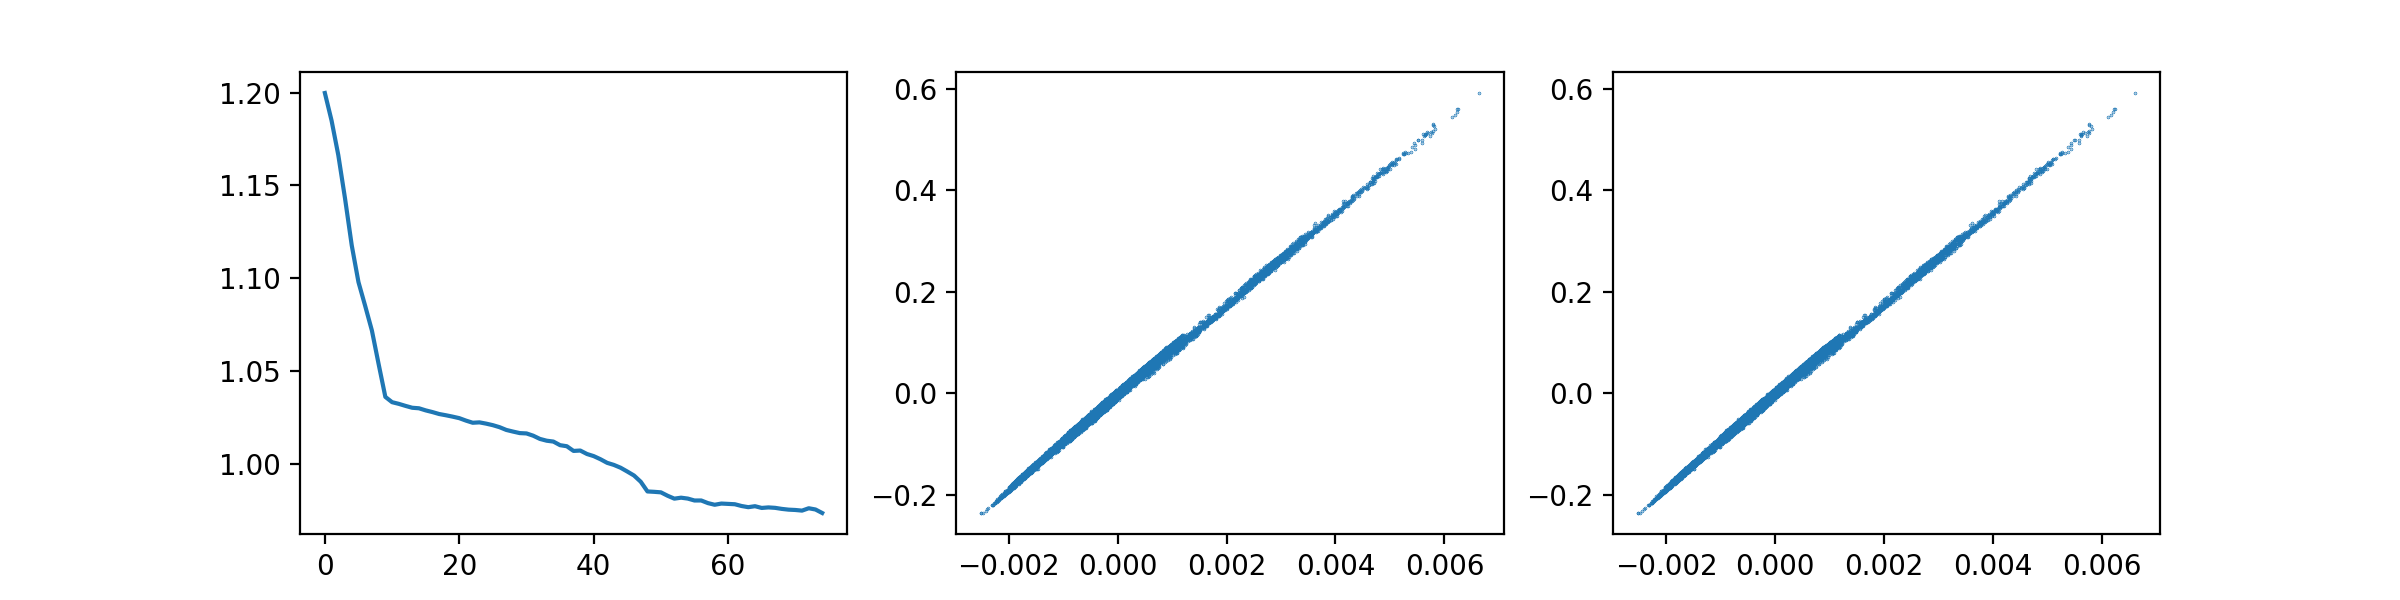

lr changed to: 9e-05
1 tensor(90.) 1.1997601985931396 tensor(0.4148, device='cuda:0')
2 tensor(12.1272) 1.184870958328247 tensor(0.3403, device='cuda:0')
3 tensor(24.6196) 1.166298747062683 tensor(0.3367, device='cuda:0')
4 tensor(37.9679) 1.1429826021194458 tensor(0.2605, device='cuda:0')
5 tensor(54.7337) 1.1177250146865845 tensor(0.1527, device='cuda:0')
lr changed to: 8.1e-05
6 tensor(63.3387) 1.0979654788970947 tensor(0.0638, device='cuda:0')
7 tensor(25.1158) 1.0851218700408936 tensor(0.0261, device='cuda:0')
8 tensor(35.1848) 1.0718767642974854 tensor(0.0192, device='cuda:0')
9 tensor(47.4339) 1.053823709487915 tensor(0.0183, device='cuda:0')
10 tensor(56.6280) 1.0361816883087158 tensor(0.0018, device='cuda:0')
lr changed to: 7.290000000000001e-05
11 tensor(67.3777) 1.0333331823349 tensor(0.0004, device='cuda:0')
12 tensor(35.6606) 1.032429575920105 tensor(0.0003, device='cuda:0')
13 tensor(52.3797) 1.0313342809677124 tensor(0.0002, device='cuda:0')
14 tensor(45.9778) 1.03032517

KeyboardInterrupt: 

In [12]:
%matplotlib notebook

k = int(batch_size*0.16)

fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(131)
ax1 = fig.add_subplot(132)
# ax2 = fig.add_subplot(133, projection='3d')
ax3 = fig.add_subplot(133)

# trace = []
change = 100
W_STOP = 1e-10
d_weigths = torch.zeros(num_of_img)
old_d_weights = torch.zeros([1, num_of_img])
torch_pi = torch.acos(torch.zeros(1)).item() * 2 

# for epoch in range(num_epoch):
step0 = 0
angle_delta = 0
while step0 < num_epoch and change > W_STOP:
# for i in range(1000):
    LOSS = 0
    old_weight = torch.clone(model.W1.weight.data)
    for step, ipt in enumerate(loader):
        model.zero_grad()
        ipt = ipt.to(device)
        
        opt = model.forward(ipt)
#------------------------------sphe2cartesin----------------------------------
        
#         opt = angle2cart(opt)
#         opt = spher2cart(opt)
    
#---------------------------------------------------------------
#         loss = entropyLoss(opt.permute(1,0), device=device)
        loss = entropy(opt, k=k, dis=1)
        loss.backward()
        optimizer.step()
        LOSS+=loss
    d_weigths = model.W1.weight.data - old_weight
    change = norm(d_weigths)**2
    d_weigths = d_weigths.cpu()
    if step > 2:
        angle_delta = torch.arccos(
                    torch.sum(d_weigths * old_d_weights) /
                    (norm(d_weigths) * norm(old_d_weights) + 1e-8)
                ) * 180 / torch_pi
    if angle_delta > 60:
        learning_rate = learning_rate * 0.9
        
        print('lr changed to:', learning_rate)
        
        optimizer.param_groups[0]['lr'] = learning_rate
        old_d_weights = torch.clone(d_weigths)
    elif step == 1:
        old_d_weights = torch.clone(d_weigths)
        
        
        
    LOSS = LOSS.cpu()
    loss_tracker.append(LOSS.detach().numpy()/len(loader.sampler))
    if step0 % 2 == 0:
        
#         index = np.random.randint(0,num_of_img, 2)
        index = [0,1]
        ax.clear()
        ax.plot(loss_tracker[-100:])
        fig.canvas.draw()
    
#         data = model.forward(IPT.T).cpu().detach().numpy()
        data1 = model.forward(IPT.T)
#         data2 = angle2cart(data1).cpu().detach().numpy()
#         data2 = spher2cart(data1).cpu().detach().numpy()
        data1 = data1.cpu().detach().numpy()
        data = (IPT.T@model.W1.weight.data.T).cpu().detach().numpy()
#         data2 = data.cpu().detach().numpy()
        ax1.clear()
        ax1.plot(data1[:, index[0]], data1[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        
#         ax2.clear()
#         ax2.scatter(data2[:,-1], data2[:,-2], data2[:,-3], c = 'r', s=0.1)

# #         ax2.set_xlim3d(-2,2)
# #         ax2.set_ylim3d(-2,2)
# #         ax2.set_zlim3d(-2,2)
#         ax2.set_xlim3d(-10,10)
#         ax2.set_ylim3d(-10,10)
#         ax2.set_zlim3d(-10,10)
        
#         fig.canvas.draw()

        ax3.clear()
        
        ax3.plot(data[:, index[0]], data[:, index[1]], '.', ms=0.5)
        fig.canvas.draw()
        

    

    step0 += 1
    print(step0, angle_delta, LOSS.detach().numpy()/len(loader.sampler), change)
    scheduler.step()